# Integrating unpaired multimodal single cell data in a shared latent space: scRNA-scATAC PBMCs

Given two single-cell datasets profiled with different modalities scConfluence can map each in low-dimensional latent space shared by both modalities where distances between cell embeddings depends only on their biological similarity. We show here an example of integration on a PBMC dataset where gene expression and chromatin accessibility were measured.

## Imports

Of note, `scikit-misc` as well as `louvain` should be installed (can be done with pip) for this notebook to be executed.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.spatial.distance import cdist
import muon as mu
import numpy as np
import anndata as ad
import scanpy as sc

import scconfluence

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data

You can download unpaired multimodal demo dataset for this tutorial from https://figshare.com/s/b0840d90e42e37fa165f.

In [2]:
mdata = mu.read_h5mu("RNA_ATAC_PBMC_demo.h5mu.gz")
mdata

MuData object with n_obs × n_vars = 8000 × 145834
  obs:	'celltype', 'modality'
  2 modalities
    rna:	4000 x 15417
    atac:	4000 x 130417
      uns:	'gene_activities_names'
      obsm:	'gene_activities'

## Perform basic quality control

We can use scanpy functions to filter out cells or features with low quality measurements, more advanced quality control could be appropriate depending on the technologies used to obtain the data.

In [3]:
sc.pp.filter_cells(mdata["rna"], min_genes=100)
sc.pp.filter_genes(mdata["rna"], min_cells=20)

sc.pp.filter_cells(mdata["atac"], min_genes=100)
# we're actually filtering peaks here
sc.pp.filter_genes(mdata["atac"], min_cells=20)
mdata.update()
mdata

MuData object with n_obs × n_vars = 8000 × 145834
  obs:	'celltype', 'modality'
  2 modalities
    rna:	4000 x 15145
      obs:	'n_genes'
      var:	'n_cells'
    atac:	4000 x 127230
      obs:	'n_genes'
      var:	'n_cells'
      uns:	'gene_activities_names'
      obsm:	'gene_activities'

## Preprocess common features and obtain cross-modality distance matrix

Diagonal integration, i.e. single cell multimodal unpaired integration, is a very challenging task as it aims at aligning cells in which different features were measured. To guide the alignment, we need to leverage prior biological knowledge to obtain a set of common features across modalities which will serve as a bridge for the integration. For RNA-ATAC integration, those common features are derived from the computation of gene activities for the ATAC data, which can be performed using tools such as [Signac](https://stuartlab.org/signac/). Once those common feature representations have been obtained, we can derive a distance matrix whose rows correspond to cells in the RNA modality and columns correspond to the cells in the ATAC modality which will be used by scConfluence.

In [4]:
cm_genes = list(set(mdata["rna"].var_names) & set(mdata["atac"].uns["gene_activities_names"]))
cm_features_rna = mdata["rna"][:, cm_genes].copy() 
atac_genes = list(mdata["atac"].uns["gene_activities_names"])
atac_genes_idx = [atac_genes.index(g) for g in cm_genes]
cm_features_atac = ad.AnnData(mdata["atac"].obsm["gene_activities"][:, atac_genes_idx])

In [5]:
sc.pp.normalize_total(cm_features_rna, target_sum=10000.)
sc.pp.log1p(cm_features_rna)
sc.pp.normalize_total(cm_features_atac, target_sum=10000.)
sc.pp.log1p(cm_features_atac)
cm_hvg_genes = sc.pp.highly_variable_genes(cm_features_rna, n_top_genes=3000, subset=False, inplace=False)
cm_features_rna = cm_features_rna[:, cm_hvg_genes["highly_variable"]].copy()
cm_features_atac = cm_features_atac[:, cm_hvg_genes["highly_variable"]].copy()

In [6]:
mdata.uns["cross_rna+atac"] = cdist(np.array(cm_features_rna.X.todense()), cm_features_atac.X)
mdata.uns["cross_keys"] = ["cross_rna+atac"]

## Preprocess each modality

While the computation of the distance matrix only involved features that were present both in the RNA modality and the ATAC-inferred gene activities, our method leverages the original features of each modalities (i.e. genes for RNA and peaks for ATAC) to perform dimension reductions. 

In [7]:
mdata["rna"].layers["counts"] = mdata["rna"].X.copy()

sc.pp.normalize_total(mdata["rna"], target_sum=10000.)
sc.pp.log1p(mdata["rna"])

# Since we use both raw and normalized gene counts it makes sense to select highly variable genes based on both
raw_hvg = sc.pp.highly_variable_genes(mdata["rna"], layer="counts", n_top_genes=3000, subset=False, inplace=False, 
                                     flavor="seurat_v3")["highly_variable"].values
norm_hvg = sc.pp.highly_variable_genes(mdata["rna"], n_top_genes=3000, subset=False, 
                                       inplace=False)["highly_variable"].values
mdata.mod["rna"] = mdata["rna"][:, np.logical_or(raw_hvg, norm_hvg)].copy()
sc.tl.pca(mdata["rna"], n_comps=100, zero_center=None)

Since there are many peaks, this preprocessing step can take up to 5 minutes but we do not encourage subsetting the scATAC data to a few thousand highly variable features as is often done with scRNA data. 

In [8]:
mu.atac.pp.tfidf(mdata["atac"], log_tf=True, log_idf=True)
sc.tl.pca(mdata["atac"], n_comps=100, zero_center=None)

## Define autoencoders for each modality

We define one autoencoder per modality whose aim is to extract all the biological information present in the original features while accounting for batch effects (not present here since there's only one batch) and projecting the cells to a shared latent space of low dimension (hence the dimension of the latent space `n_latent` should be the same for all autoencoders). Multiple options can be set to adapt the autoencoders to the specificity of the modalities measured, see the API documentation for details about the arguments. 

In [9]:
import torch
torch.manual_seed(1792)
autoencoders = {"rna": scconfluence.unimodal.AutoEncoder(mdata["rna"], 
                                                         modality="rna", 
                                                         rep_in="X_pca", 
                                                         rep_out="counts", 
                                                         batch_key=None,
                                                         n_hidden=64, 
                                                         n_latent=16, 
                                                         type_loss="zinb"),
                "atac": scconfluence.unimodal.AutoEncoder(mdata["atac"], 
                                                          modality="atac", 
                                                          rep_in="X_pca", 
                                                          rep_out=None, 
                                                          batch_key=None,
                                                          n_hidden=64, 
                                                          n_latent=16, 
                                                          type_loss="l2",
                                                          reconstruction_weight=5.)}

## Create and train the model

The scConfluence model leverages the distance matrix stored in `mdata` to align the latent embeddings learned by autoencoders from each modality. We used here the default parameters, see the API's documention for details on their meaning. While the maximum over of epochs is set to 1000, we use earlystopping to interrupt the training when the loss has converged on validation samples which generally happens long before the upper limit of 1000 epochs. With a GPU, this training is expected to take less than 20 minutes.

In [10]:
%%time
model = scconfluence.model.ScConfluence(mdata=mdata, unimodal_aes=autoencoders, 
                                        mass=0.5, reach=0.3, iot_loss_weight=0.01, sinkhorn_loss_weight=0.1)
model.fit(save_path="demo_rna_atac", use_cuda=True, max_epochs=1000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /pasteur/appa/homes/jsamaran/scConfluence/demo_rna_atac exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | aes  | ModuleDict | 9.1 M 
------------------------------------
9.1 M     Trainable params
0         Non-trainable params
9.1 M     To

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|████████████████████████| 13/13 [00:06<00:00,  1.99it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████| 13/13 [00:06<00:00,  2.03it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████| 13/13 [00:06<00:00,  2.03it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|████████████████████████| 13/13 [00:06<00:00,  2.01it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|████████████████████████| 13/13 [00:06<00:00,  1.99it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|████████████████████████| 13/13 [00:06<00:00,  2.00it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████████

Epoch 25: 100%|███████████████████████| 13/13 [00:05<00:00,  2.17it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|███████████████████████| 13/13 [00:05<00:00,  2.19it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|███████████████████████| 13/13 [00:05<00:00,  2.18it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|███████████████████████| 13/13 [00:05<00:00,  2.25it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|███████████████████████| 13/13 [00:06<00:00,  2.13it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|███████████████████████| 13/13 [00:06<00:00,  2.08it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|█████████████

Epoch 49: 100%|███████████████████████| 13/13 [00:05<00:00,  2.27it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|███████████████████████| 13/13 [00:05<00:00,  2.25it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 51: 100%|███████████████████████| 13/13 [00:05<00:00,  2.23it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 52: 100%|███████████████████████| 13/13 [00:05<00:00,  2.23it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|███████████████████████| 13/13 [00:05<00:00,  2.21it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 54: 100%|███████████████████████| 13/13 [00:06<00:00,  2.15it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 55: 100%|█████████████

Epoch 73: 100%|███████████████████████| 13/13 [00:05<00:00,  2.32it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 74: 100%|███████████████████████| 13/13 [00:05<00:00,  2.25it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 75: 100%|███████████████████████| 13/13 [00:05<00:00,  2.23it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 76: 100%|███████████████████████| 13/13 [00:05<00:00,  2.17it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 77: 100%|███████████████████████| 13/13 [00:05<00:00,  2.24it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 78: 100%|███████████████████████| 13/13 [00:05<00:00,  2.22it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 79: 100%|█████████████

Epoch 97: 100%|███████████████████████| 13/13 [00:05<00:00,  2.43it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 98: 100%|███████████████████████| 13/13 [00:05<00:00,  2.37it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|███████████████████████| 13/13 [00:05<00:00,  2.37it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 100: 100%|██████████████████████| 13/13 [00:05<00:00,  2.35it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 101: 100%|██████████████████████| 13/13 [00:05<00:00,  2.33it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 102: 100%|██████████████████████| 13/13 [00:05<00:00,  2.32it/s, v_num=16]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 103: 100%|████████████

Epoch 121: 100%|██████████████████████| 13/13 [00:06<00:00,  1.98it/s, v_num=16]
CPU times: user 3min 10s, sys: 11min 12s, total: 14min 22s
Wall time: 14min 36s


## Obtaining and visualizing latent embeddings of all cells

In [11]:
mdata.obsm["latent"] = model.get_latent(use_cuda=True).loc[mdata.obs_names]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:06<00:00,  2.56it/s]


While conclusions should not be drawn from UMAP plots we use it here to visualize the results of the integration.

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


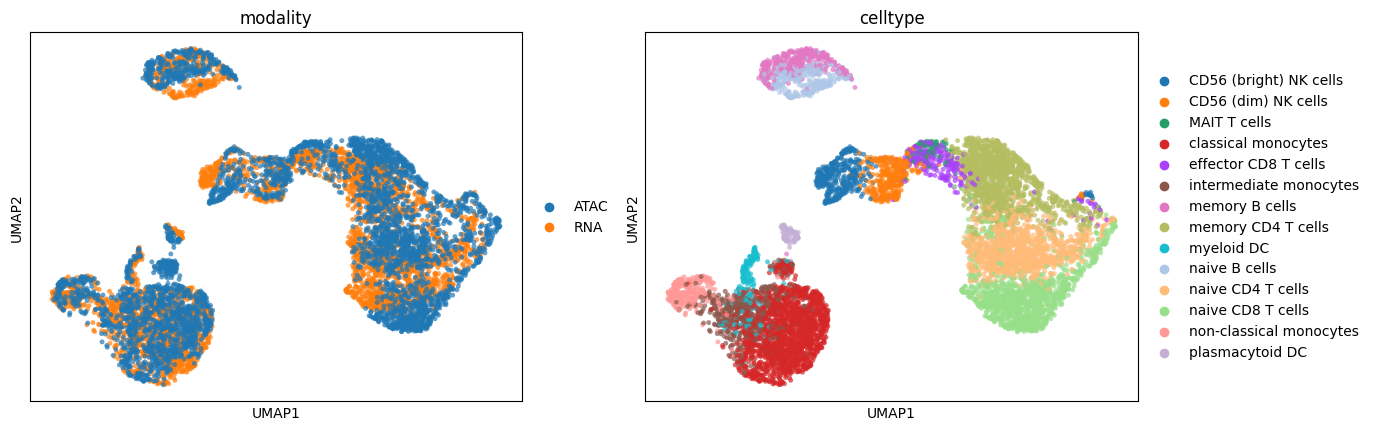

In [12]:
sc.pp.neighbors(mdata, use_rep="latent", key_added="scConfluence")
sc.tl.umap(mdata, neighbors_key="scConfluence")
sc.pl.umap(mdata, color=["modality", "celltype"], size=50, alpha=0.7)

## Clustering the latent embeddings

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


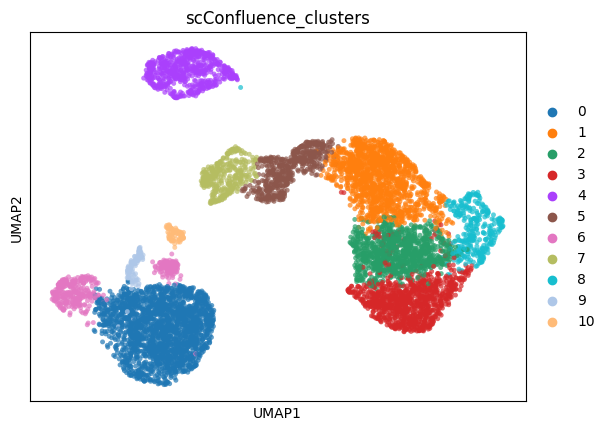

In [13]:
sc.tl.louvain(mdata, resolution=.5, neighbors_key='scConfluence', key_added='scConfluence_clusters')
sc.pl.umap(mdata, color=['scConfluence_clusters'], size=50, alpha=0.7)